# overview
#### This kernel is based on hiromu [2020 Starter Kernel Women](https://www.kaggle.com/hiromoon166/2020-women-s-starter-kernel).
#### I improve it using Random Forest Regressor
#### Please don't forget to upvote original kernel :)

## Import Library & Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import warnings; 
warnings.filterwarnings("ignore") 
import os 
os.environ['OMP_NUM_THREADS'] = '8' # speed up using 8 cpu

In [2]:
tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneySeeds.csv')

In [3]:
# deleting unnecessary columns
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result

,Season,WTeamID,LTeamID
0,1998,3104,3422
1,1998,3112,3365
2,1998,3163,3193
3,1998,3198,3266
4,1998,3203,3208
...,...,...,...
1381,2019,3124,3234
1382,2019,3323,3390
1383,2019,3124,3332
1384,2019,3323,3163


## Merge Seed

In [4]:
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1998,3104,3422,X02,X15
1,1998,3112,3365,W03,W14
2,1998,3163,3193,W02,W15
3,1998,3198,3266,Y07,Y10
4,1998,3203,3208,W10,W07
...,...,...,...,...,...
1381,2019,3124,3234,Y01,Y02
1382,2019,3323,3390,X01,X02
1383,2019,3124,3332,Y01,Z02
1384,2019,3323,3163,X01,W02


In [5]:
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1998,3104,3422,2,15
1,1998,3112,3365,3,14
2,1998,3163,3193,2,15
3,1998,3198,3266,7,10
4,1998,3203,3208,10,7
...,...,...,...,...,...
1381,2019,3124,3234,1,2
1382,2019,3323,3390,1,2
1383,2019,3124,3332,1,2
1384,2019,3323,3163,1,2


## Merge Score

In [6]:
season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WRegularSeasonCompactResults.csv')

In [7]:
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_result

,Season,TeamID,Score
0,1998,3104,91
1,1998,3163,87
2,1998,3222,66
3,1998,3307,69
4,1998,3349,115
...,...,...,...
214019,2019,3251,49
214020,2019,3179,79
214021,2019,3335,54
214022,2019,3144,45


In [8]:
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_score

,Season,TeamID,Score
0,1998,3102,1375
1,1998,3103,2008
2,1998,3104,2297
3,1998,3106,1286
4,1998,3108,1560
...,...,...,...
7350,2019,3462,1765
7351,2019,3463,1837
7352,2019,3464,1976
7353,2019,3465,1905


In [9]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreT,LScoreT
0,1998,3104,3422,2,15,2297,2010
1,1998,3112,3365,3,14,2116,2144
2,1998,3163,3193,2,15,2696,1950
3,1998,3198,3266,7,10,2337,1907
4,1998,3203,3208,10,7,1818,1996
...,...,...,...,...,...,...,...
1381,2019,3124,3234,1,2,2575,2555
1382,2019,3323,3390,1,2,2938,2393
1383,2019,3124,3332,1,2,2575,2725
1384,2019,3323,3163,1,2,2938,2726


In [10]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)
tourney_win_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,2,15,2297,2010
1,3,14,2116,2144
2,2,15,2696,1950
3,7,10,2337,1907
4,10,7,1818,1996
...,...,...,...,...
1381,1,2,2575,2555
1382,1,2,2938,2393
1383,1,2,2575,2725
1384,1,2,2938,2726


In [11]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']
tourney_lose_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,15,2,2010,2297
1,14,3,2144,2116
2,15,2,1950,2696
3,10,7,1907,2337
4,7,10,1996,1818
...,...,...,...,...
1381,2,1,2555,2575
1382,2,1,2393,2938
1383,2,1,2725,2575
1384,2,1,2726,2938


## Prepare Training Data

In [12]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [13]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,2,15,2297,2010,-13,287,1
1,3,14,2116,2144,-11,-28,1
2,2,15,2696,1950,-13,746,1
3,7,10,2337,1907,-3,430,1
4,10,7,1818,1996,3,-178,1
...,...,...,...,...,...,...,...
2767,2,1,2555,2575,1,-20,0
2768,2,1,2393,2938,1,-545,0
2769,2,1,2725,2575,1,150,0
2770,2,1,2726,2938,1,-212,0


## Train

In [14]:
X_train = tourney_result.drop('result', axis=1)
y_train = tourney_result.result
X_train, y_train = shuffle(X_train, y_train)

In [15]:
clf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=50, verbose=1, warm_start=False)

clf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=50, verbose=1, warm_start=False)

## Prepare Test Data

In [16]:
test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')

In [17]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_3106_3107,0.5,2015,3106,3107
1,2015_3106_3110,0.5,2015,3106,3110
2,2015_3106_3113,0.5,2015,3106,3113
3,2015_3106_3114,0.5,2015,3106,3114
4,2015_3106_3116,0.5,2015,3106,3116
...,...,...,...,...,...
10075,2019_3413_3417,0.5,2019,3413,3417
10076,2019_3413_3460,0.5,2019,3413,3460
10077,2019_3416_3417,0.5,2019,3416,3417
10078,2019_3416_3460,0.5,2019,3416,3460


In [18]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df

,ID,Pred,Season,WTeamID,LTeamID,Seed1,Seed2,ScoreT1,ScoreT2
0,2015_3106_3107,0.5,2015,3106,3107,Y15,X13,1692,2221
1,2015_3106_3110,0.5,2015,3106,3110,Y15,Z14,1692,2027
2,2015_3106_3113,0.5,2015,3106,3113,Y15,Y03,1692,2174
3,2015_3106_3114,0.5,2015,3106,3114,Y15,Y11,1692,2089
4,2015_3106_3116,0.5,2015,3106,3116,Y15,Z10,1692,1809
...,...,...,...,...,...,...,...,...,...
10075,2019_3413_3417,0.5,2019,3413,3417,X15,W06,2132,2346
10076,2019_3413_3460,0.5,2019,3413,3460,X15,X13,2132,2246
10077,2019_3416_3417,0.5,2019,3416,3417,Z12,W06,1973,2346
10078,2019_3416_3460,0.5,2019,3416,3460,Z12,X13,1973,2246


In [19]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,15,13,1692,2221,2,-529
1,15,14,1692,2027,1,-335
2,15,3,1692,2174,12,-482
3,15,11,1692,2089,4,-397
4,15,10,1692,1809,5,-117
...,...,...,...,...,...,...
10075,15,6,2132,2346,9,-214
10076,15,13,2132,2246,2,-114
10077,12,6,1973,2346,6,-373
10078,12,13,1973,2246,-1,-273


## Predict & Make Submission File

In [20]:
test_preds = clf.predict(test_df)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


In [21]:
submission_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = test_preds
submission_df

,ID,Pred
0,2015_3106_3107,0.344514
1,2015_3106_3110,0.435376
2,2015_3106_3113,0.017384
3,2015_3106_3114,0.314835
4,2015_3106_3116,0.327731
...,...,...
10075,2019_3413_3417,0.062382
10076,2019_3413_3460,0.391071
10077,2019_3416_3417,0.210152
10078,2019_3416_3460,0.468877


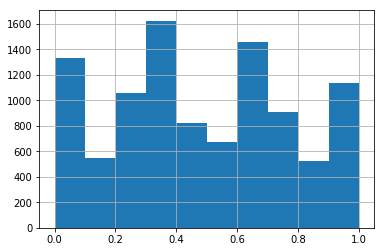

In [22]:
submission_df['Pred'].hist()

In [23]:
submission_df.to_csv('submission.csv', index=False)